SETUP UTILIZADO

In [1]:
# Instalando a biblioteca SIDETABLE

%%capture
%pip install sidetable

In [47]:
# Importando as bibiotecas necessarias para a realizacao do desafio

import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale,PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from yellowbrick.cluster import silhouette_visualizer

from yellowbrick.cluster import kelbow_visualizer

In [3]:
# Configurando o padrao dos graficos que serao utilizados

sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

# ETAPA 01 - ANALISE EXPLORATORIA DOS DADOS

IMPORTANDO DATASET

In [4]:
# Importando e vendo a base de dados

df = pd.read_csv('/content/data (2).csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


DATA UNDERSTANDING

In [5]:
# Verificando os tipos de dados e entendendo os mesmos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# Entendendo porque as colunas InvoiceNo e StockCode estao como objeto (elas sao cofigos alfanumericos e nao somente numeros)
# A variavel StockCode nao tem influencia na analise, iremos tratar isso na etapda de data praparation

df[['InvoiceNo', 'StockCode']].sort_values(by=['InvoiceNo', 'StockCode'])

,InvoiceNo,StockCode
6,536365,21730
5,536365,22752
1,536365,71053
4,536365,84029E
3,536365,84029G
...,...,...
540449,C581490,23144
541541,C581499,M
541715,C581568,21258
541717,C581569,20979


In [7]:
# Verificando a quantidade de itens e paises distintos

df[['Description','Country']].nunique()

,0
Description,4223
Country,38


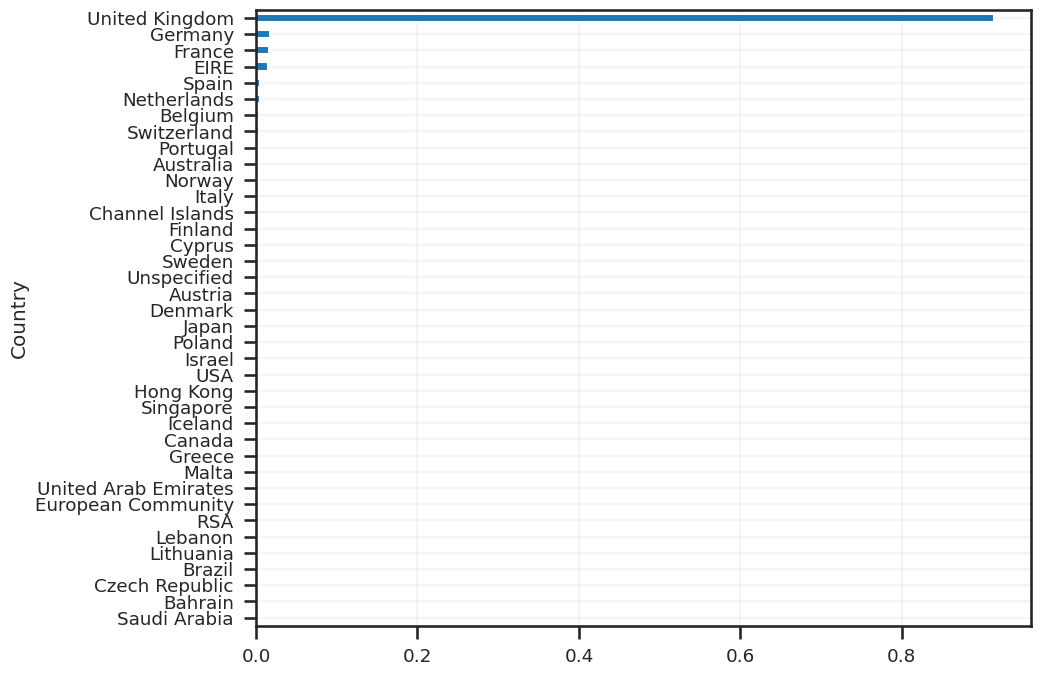

In [8]:
# Vendo a distribuicao das compras por paises

df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(10,8));

In [9]:
# Verifcando as variaveis numericas (Podemos ver que temos valores negativos e que nao fazem sentido. Iremos tratar-los)

df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [10]:
# Verificando a existencia de dados nulos, que serao tratados na etapa de data preparation

df.isna().sum().sort_values(ascending=False)

,0
CustomerID,135080
Description,1454
InvoiceNo,0
StockCode,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [11]:
# Verificando a existencia de dados duplicados, que serao tratados na etapa de data preparation

df.duplicated().sum()

5268

# ETAPA 02 - PRE-PROCESAMENTO DOS DADOS

DATA CLEANING E DATA PREPARATION

In [12]:
# Verificando os dados faltantes para tratarmentos

df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [13]:
# Eliminando os dados nulos da coluna CustomerID

df = df.dropna(subset=['CustomerID'])

In [14]:
# Verificando que agora todos dados nulos foram retirados do dataset

df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [15]:
# Alterando as variaveis para os tipos corretos

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', errors='coerce')
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')


<ipython-input-15-8ccd59515013>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', errors='coerce')
<ipython-input-15-8ccd59515013>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-15-8ccd59515013>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [17]:
# Eliminando os valores negativos nas columas Quantity e UnitPrice

df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [18]:
# Verificando as datas minimas e maximas do dataset

df.InvoiceDate.agg(['min','max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


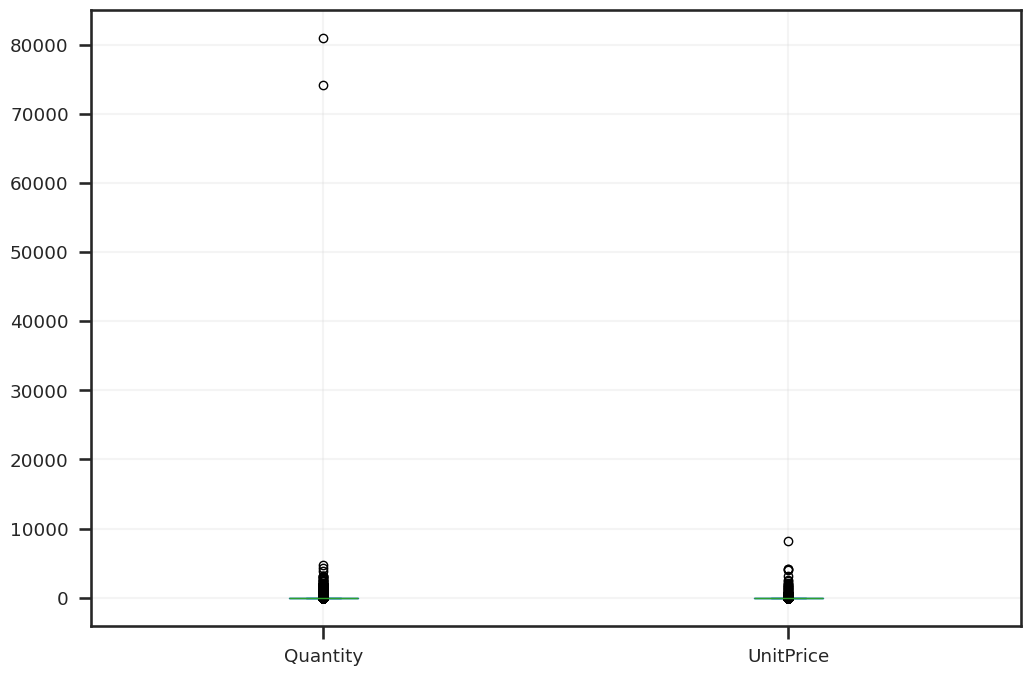

In [19]:
# Verificacao de outliers para as variaveis numericas

df[['Quantity','UnitPrice']].plot.box();

In [20]:
# Vendo quais sao os itens acima de 10000 na coluna Quantity

df.query('Quantity>10000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


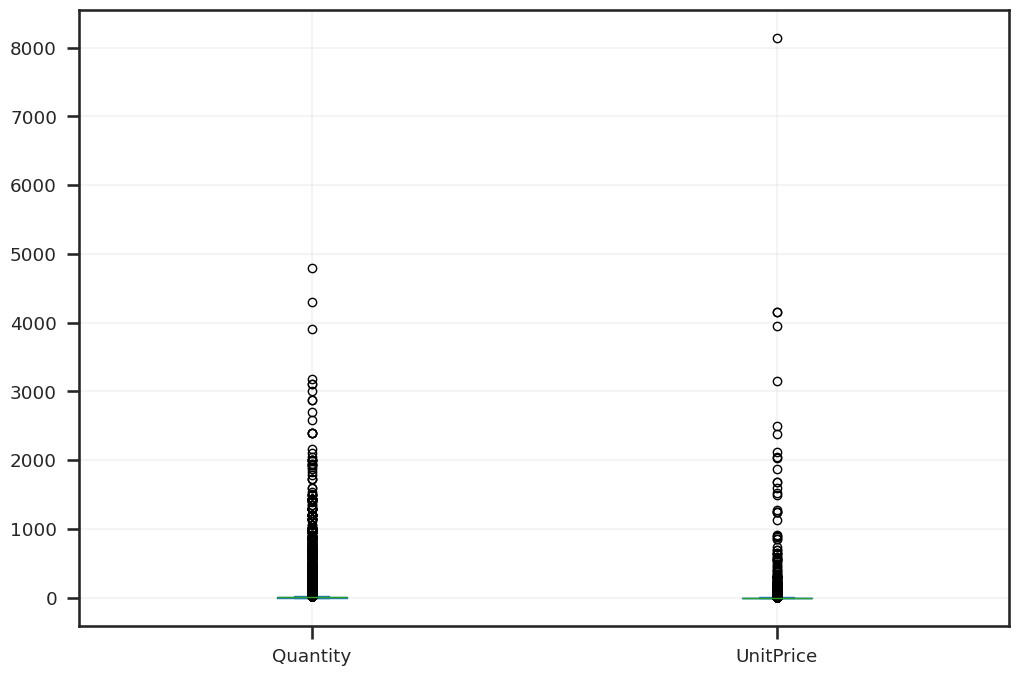

In [21]:
# Considerando um ponto de corte , os valores abaixo de 1000 para a columa Quantity, vamo ver os outliers restantes na coluna UnitPrice

df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box();

In [22]:
# verificando o item do outlier acima de 8000 na columa UnitedPrice

df.query('UnitPrice>8000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [23]:
# Eliminando os outliers, considerando uma premissa de corte de valores acima de 10000 para coluna Quantity e valores acima de 8000 para a coluna UnitPrice

df = df.query('Quantity<10000 & UnitPrice<8000')

In [24]:
# Criando a columa total price

df['total_price'] = df.Quantity * df.UnitPrice
df.head()

<ipython-input-24-ae9d03efe5a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_price'] = df.Quantity * df.UnitPrice


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


ELABORACAO DAS METRICAS RFM

As features necessárias para calcular o RFM foram InvoiceDate, InvoiceNo, Quantity, e UnitPrice.

RFM significa Recência, Frequência e Valor Monetário, e é uma técnica usada para segmentar clientes com base em seu comportamento de compra. Para calcular essas métricas, as seguintes features são necessárias e como foram usadas:

Recência (R):

InvoiceDate: Usada para calcular a data da última compra do cliente. A recência é então calculada como a diferença entre a data da última compra e a data de análise (data de hoje ou uma data de referência no passado). Neste código, a data de referência foi definida como '2012-01-01'.
Frequência (F):

InvoiceNo: Usada para contar o número de compras únicas feitas pelo cliente dentro de um período. Cada número de nota fiscal único representa uma transação separada.
Valor Monetário (M):

Quantity: Representa a quantidade de itens comprados em cada transação.
UnitPrice: Representa o preço unitário de cada item.
total_price: Uma nova feature criada neste código, calculada como Quantity * UnitPrice, para representar o valor total de cada transação. Em seguida, a média do total_price é usada para calcular o valor monetário (M) para cada cliente.

In [25]:
# Fazendo os calculos e agrupamentos para gerar o RFM

rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('total_price', 'mean')
  )
)

# Verificando o resultato do algoritmo

rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


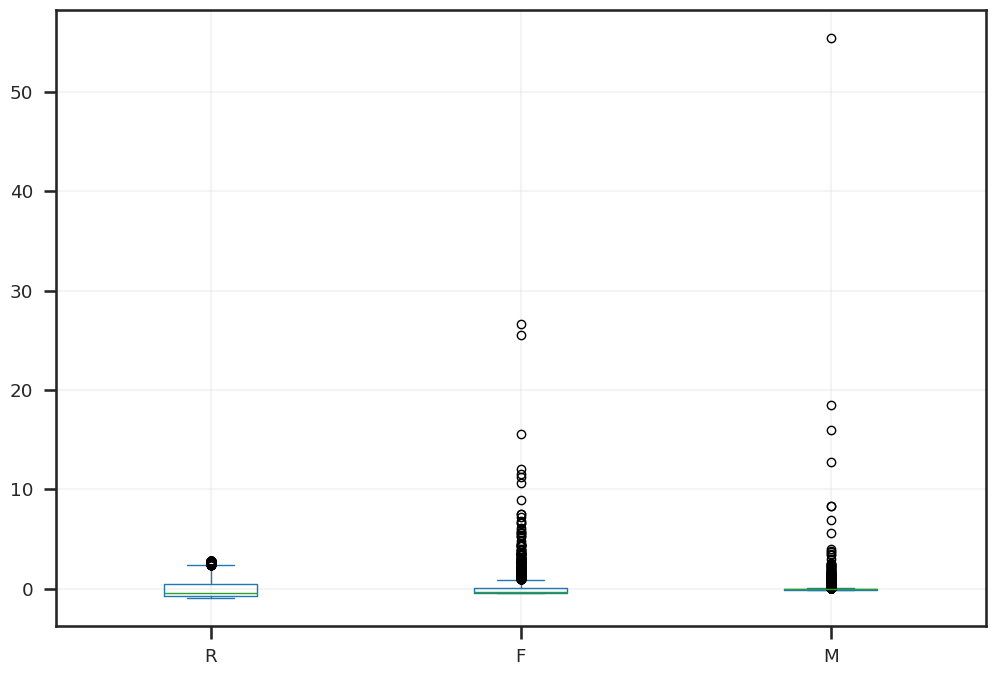

In [26]:
# Verificando os outliers para as variaveis do RFM

rfm.apply(scale).plot.box();

In [27]:
# Verificando o CustormerID com M maior que 50

rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.899878,-0.165317,55.434876


In [28]:
# Verificando no dataset principal quais os valores das compras do CustomerID 15098. Podemos ver que na segunda linha, temos um possivel erro de insercao dos dados no dataseet

df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [29]:
# Eliminando o possivel erro (o CustomerID eum index no dataset RFM)

rfm = rfm.drop(15098)

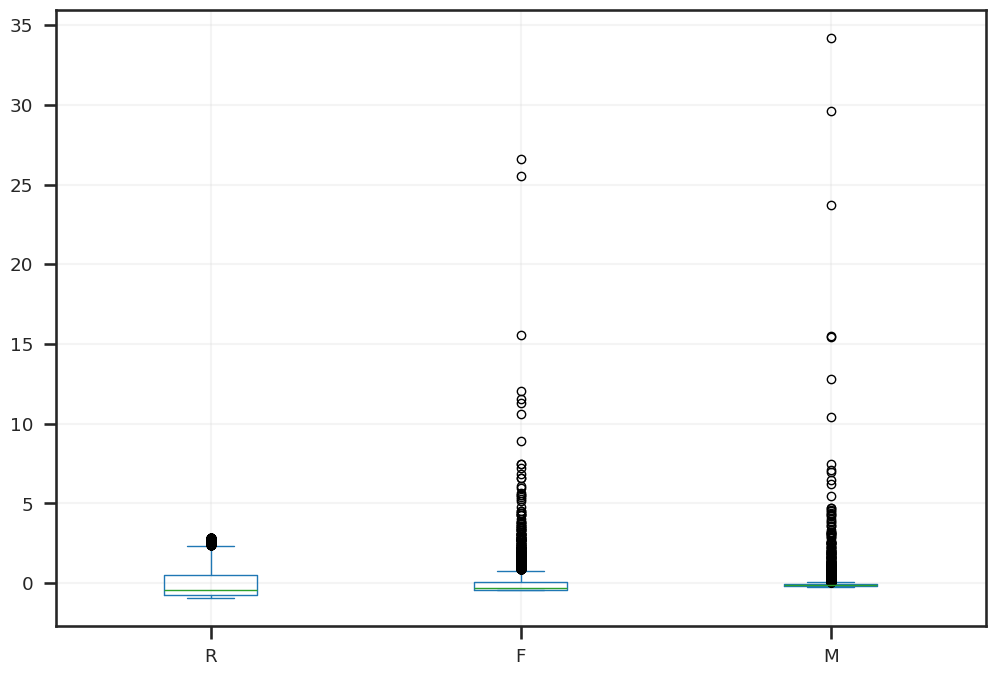

In [30]:
rfm.apply(scale).plot.box();

In [31]:
# Fazendo a normalizacao dos dados

scaler = PowerTransformer()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm), index=rfm.index, columns=rfm.columns)
rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


<Axes: >

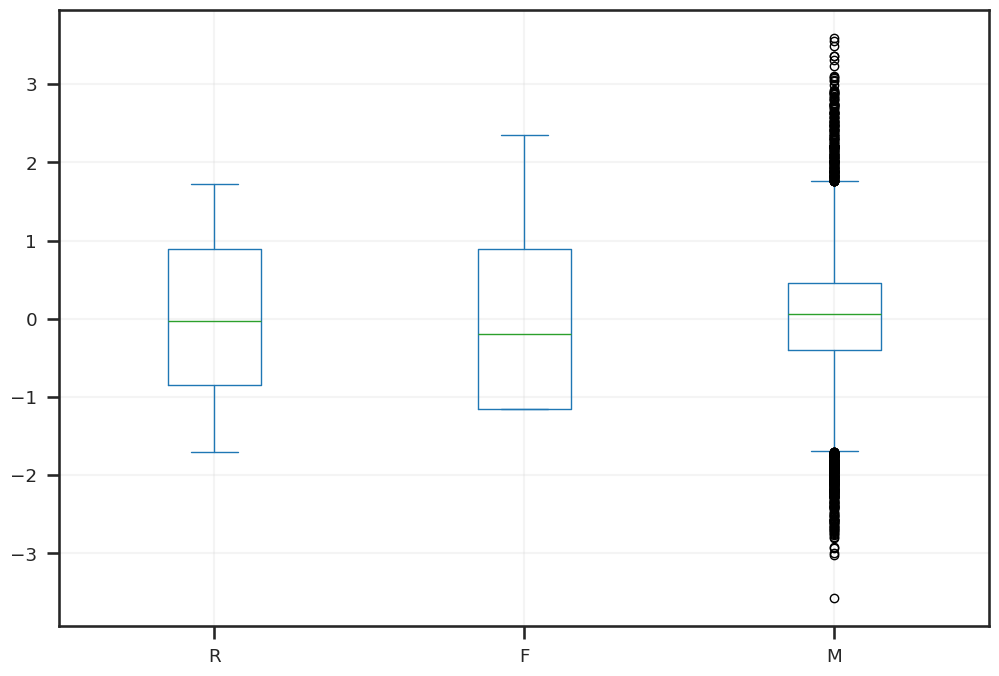

In [32]:
# Revendo os outliers apos a normalizacao

rfm_scaled.plot.box()

In [33]:
rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


In [34]:
# Aplicando a tecnica do clip para diminuir os outliers

rfm_clip = rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [35]:
# Fazendo a padronizacao dos dados

rfm_clip_scaled = rfm_clip.apply(scale)

# ETAPA 03 - SELECIONANDO ALGORITMO DE CLUSTERIZACAO

KMEANS

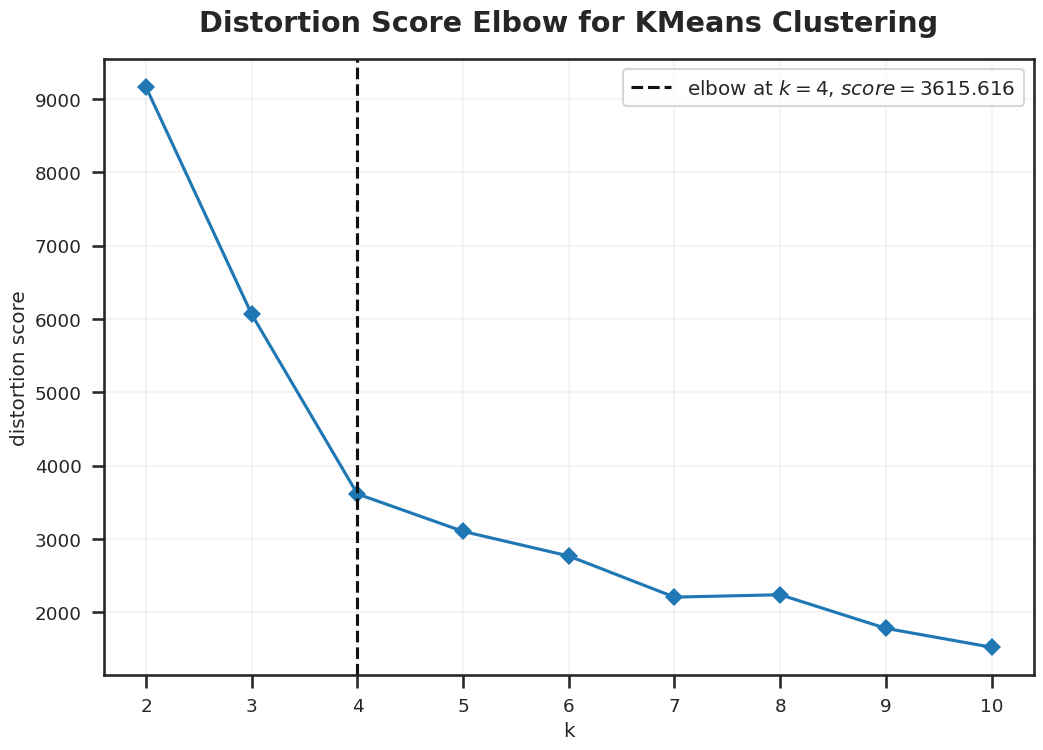

In [36]:
# Fazendo o metodo de elbow para ajustar o numero de cluster

kelbow_visualizer(KMeans(), rfm_clip_scaled, k=10, timings=False);

In [37]:
# Verificando as metricas do modelo para os valores diferentes tipos de k

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9608.319042,0.481575,1.042550,1533.485432
3,6380.827963,0.395222,0.918987,2250.147145
4,3615.611638,0.479553,0.704462,3751.144746
5,3104.989759,0.386168,0.855067,3453.313624
6,2542.521220,0.397775,0.851237,3564.616053
7,2240.392476,0.401925,0.849436,3467.623360
8,1907.087195,0.383633,0.862005,3598.989252
9,1668.788329,0.394132,0.800834,3675.183274
10,1516.652722,0.351693,0.887890,3641.928356


In [38]:
# Fazendo o algoritmo do KMEANS para k = 4
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(rfm_clip_scaled)

In [39]:
# Vendo graficamente o resultado da clusterizacao com KMEANS

px.scatter_3d(rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

HIERACHICAL CLUSTERING

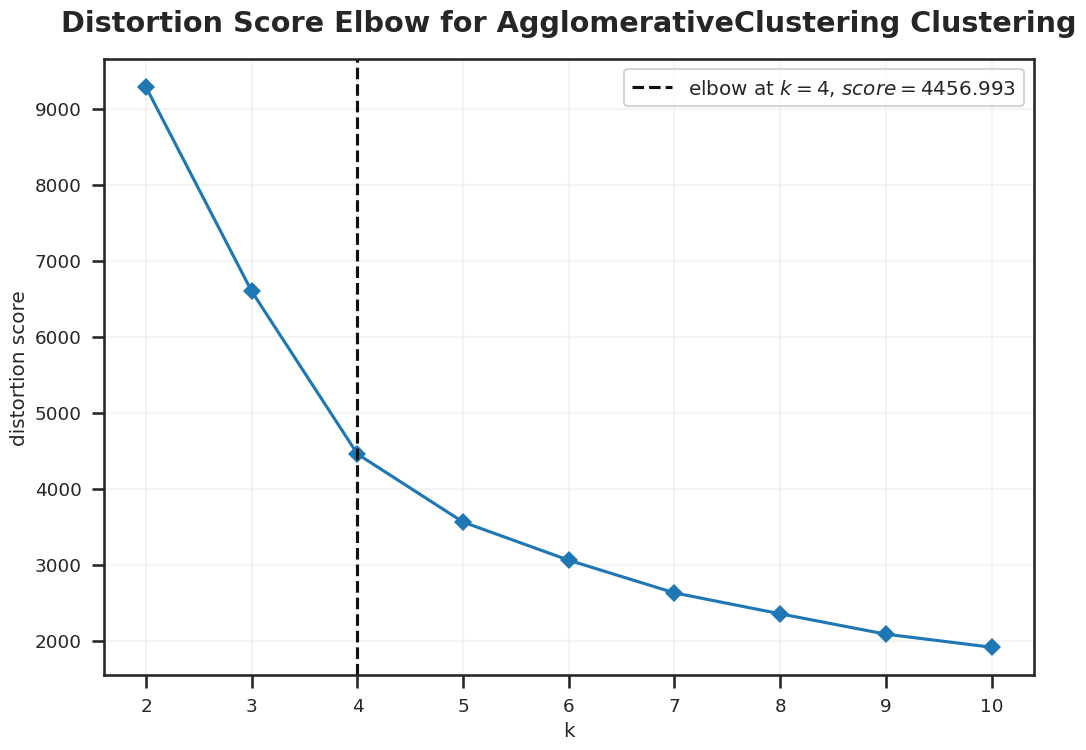

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [40]:
# Fazendo o metodo de elbow para ajustar o numero de cluster

kelbow_visualizer(AgglomerativeClustering(), rfm_clip_scaled, k=10, timings=False)

In [41]:
# Verificando as metricas do modelo para os valores diferentes tipos de k

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [42]:
# Fazendo o algoritmo do Hierachical Clustering para k = 4

hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(rfm_clip_scaled)

In [43]:
# Vendo graficamente o resultado da clusterizacao com KMEANS

px.scatter_3d(rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

Entre os dois algoritmos testatos , iremos escolher o KMEANS, atraves de uma analise grafica dos clusters.

-

O algoritmo K-Means foi utilizado neste modelo por diversos motivos:

1. Simplicidade e Eficiência: O K-Means é um algoritmo de fácil implementação e computacionalmente eficiente, tornando-o ideal para conjuntos de dados com um número moderado de features e observações, como o caso deste dataset de e-commerce.

2. Boa Performance em Dados com Clusters Esféricos: K-Means tende a performar bem quando os clusters subjacentes nos dados têm formato aproximadamente esférico. Na análise de RFM, frequentemente observamos clusters com essa característica.

3. Facilidade de Interpretação dos Resultados: Os resultados do K-Means são fáceis de interpretar, pois o algoritmo atribui cada ponto de dado a um cluster específico. Isso permite uma análise clara dos diferentes grupos de clientes e seus comportamentos de compra.

4. Objetivo da Análise: O objetivo da análise era segmentar os clientes com base em seus comportamentos de compra (Recência, Frequência e Valor Monetário). O K-Means é adequado para essa tarefa, pois agrupa clientes com características semelhantes em clusters distintos.

5. Resultados Satisfatórios: No caso deste modelo, o K-Means gerou clusters com características distintas e interpretáveis, como "clientes recentes com alto valor de compra" e "clientes inativos com baixo valor de compra". Esses resultados foram considerados satisfatórios para o objetivo da análise.

6. Comparação com Outros Algoritmos: Em alguns casos, o Hierarchical Clustering também foi considerado, mas o K-Means apresentou melhor resultado na análise visual e nas métricas de avaliação.

Em resumo, o K-Means foi escolhido por sua simplicidade, eficiência, adequação ao tipo de dado e objetivo da análise, facilidade de interpretação dos resultados e performance satisfatória no contexto do problema.

# ETAPA 04 - ANALISE DOS CLUSTERS

In [44]:
# Fazendo analises graficas com os clusters obtidos em funcoes das variaveis RFM
centers = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_clip_scaled.columns)

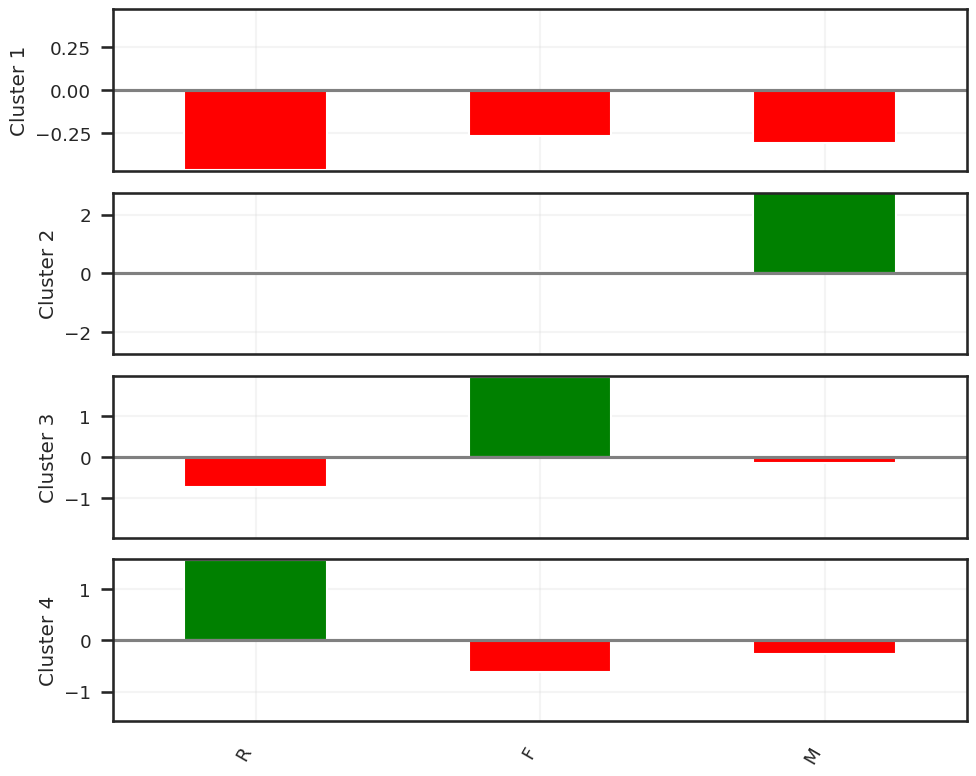

In [45]:
ig,axes = plt.subplots(nrows=4, figsize=(10,8), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

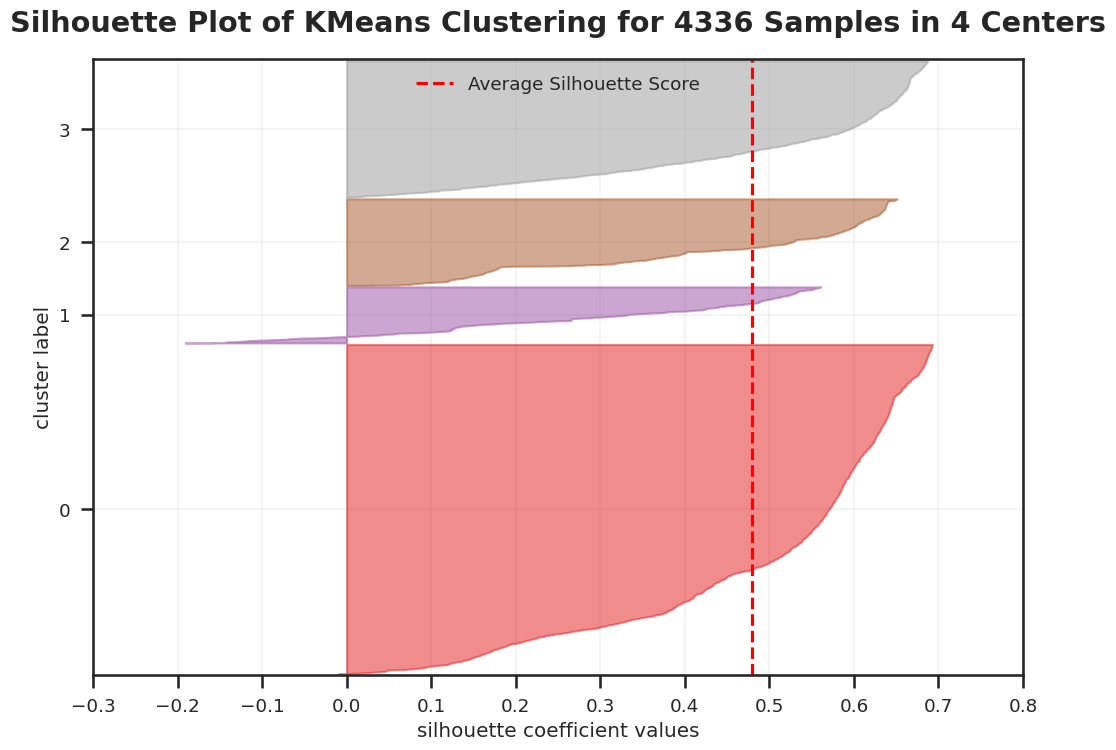

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4336 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4))

In [48]:
# silhouette_visualizer
silhouette_visualizer(KMeans(n_clusters=4), X)

In [49]:
# Fazendo algumas analises numericas com os clusters obtidos em funcoes das variaveis RFM
(
  rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,67.523221,121.057935,41.517018,261.082051
F,2.703877,3.876574,10.191248,1.509744
M,17.120301,80.714098,20.426973,18.104189


# ETAPA 05 - RESULTADOS OBTIDOS

ANALISE FINAL

Análise dos Clusters

Cluster 0:

R: 67.52 (recente)
F: 2.70 (relativamente pouco frequente)
M: 17.12 (baixo gasto)

Análise: Este grupo representa clientes que compraram recentemente, mas têm baixa frequência e baixo gasto. Eles podem ser novos clientes que ainda não se consolidaram.

Cluster 1:

R: 41.52 (muito recente)
F: 10.19 (frequente)
M: 20.42 (gasto médio)

Análise: Esses são clientes com alta frequência de compras e gasto moderado. Eles provavelmente são clientes leais que valorizam a marca, mas não são os maiores gastadores.

Cluster 2:

R: 121.06 (menos recente)
F: 3.88 (fugindo do padrão)
M: 80.71 (alto gasto)

Análise: Esse grupo possui gastadores significativos, mas não compraram recentemente. Isso pode indicar uma possível perda de interesse ou necessidade de retenção.

Cluster 3:

R: 261.08 (longa recência)
F: 1.51 (pouca frequência)
M: 18.10 (baixo gasto)

Análise: Este são clientes que não compram há muito tempo e não gastam muito. Este grupo é o mais crítico para reengajamento.




PLANOS DE ACAO PROPOSTOS

Para o Cluster 0 (novos clientes):

Objetivo: Engajamento e fidelização.
Ações:
Enviar e-mails de boas-vindas com ofertas especiais ou descontos.
Incentivar compras adicionais através de cupons de desconto ou promoções.
Realizar follow-ups para entender a experiência de compra.


Para o Cluster 1 (clientes frequentes):

Objetivo: Aumentar o gasto médio.
Ações:
Oferecer programas de fidelidade com recompensas.
Propor vendas cruzadas (cross-selling) e vendas adicionais (up-selling) em suas compras.
Implementar campanhas de marketing direcionadas com produtos relacionados.


Para o Cluster 2 (alta capacidade de gasto, mas inativos):

Objetivo: Reengajar clientes de alto valor.
Ações:
Enviar campanhas de reativação com ofertas especiais para incentivá-los a voltar a comprar.
Realizar pesquisas para entender por que reduziram as compras.
Oferecer promoções exclusivas ou eventos VIP.


Para o Cluster 3 (clientes inativos):

Objetivo: Recuperação de clientes.
Ações:
Campanhas de "sentindo sua falta", oferecendo incentivos para uma nova compra.
Enviar e-mails personalizados com recomendações de produtos que eles compraram antes.
Criar conteúdos que possam reengajá-los, como blogs ou tutoriais relacionados aos produtos que eles compraram.

#Etapas de Desenvolvimento
**Etapa 01:** Análise Exploratória dos Dados
Iniciei o projeto carregando a base de dados e realizando uma descrição estatística para entender as variáveis disponíveis. A visualização das distribuições foi crucial para identificar a relevância das colunas para a análise. Além disso, verifiquei a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.

-

**Etapa 02:** Pré-processamento dos Dados
Realizei a normalização dos dados para garantir que todas as variáveis estivessem na mesma escala.
Selecionei as variáveis mais relevantes para o modelo, assegurando que apenas os dados pertinentes fossem utilizados.
Removi dados nulos, duplicados e outliers para garantir a qualidade da análise.

-

**Etapa 03:** Seleção do Algoritmo de Clusterização
Escolhi o algoritmo K-Means para a clusterização:

Encontrei a quantidade ideal de clusters utilizando os métodos de Elbow e Silhouette Score.
Implementei o algoritmo K-Means para agrupar os clientes com base em seu comportamento de compras.

-

**Etapa 04:** Análise dos Clusters Obtidos
Após a aplicação do algoritmo, analisei os clusters resultantes para identificar padrões e características em comum entre os clientes. Utilizei gráficos e visualizações para auxiliar na análise e interpretação dos resultados.

-

**Etapa 05:** Interpretação dos Resultados Obtidos
Descrevi o perfil de compras dos clientes em cada cluster, identificando padrões de comportamento.
Justifiquei como essa análise pode ser útil para a empresa na segmentação de seus clientes e na personalização das campanhas de marketing.
Sugeri ações práticas baseadas nos insights obtidos, como o direcionamento de promoções específicas para diferentes clusters de clientes.

-

**Conclusão:**
Ao final deste desafioo, obtive uma compreensão mais profunda do comportamento dos clientes da empresa de e-commerce através da análise de clustering das métricas RFV. Esses insights podem ser utilizados para segmentar melhor a base de clientes e personalizar campanhas de marketing, resultando em um aumento na eficácia das estratégias de vendas.